In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
from matplotlib import lines
import numpy as np 
import seaborn as sns
sns.set_style('ticks')
default_colors = sns.color_palette()

import pandas as pd 

import CRISPR_Kinetic_model as Cas9
reload(Cas9);

# Pattanayak data (CLTA1)

In [2]:
fldr = '../Pattanayak_data/'
Pattanayak = pd.read_excel(fldr+'Pattanayak_Liu_NBT_2673_Data.xlsx')
concentration = '100nM'
PAM = 'NGG'
name = 'CLTA1'

Pattanayak = Pattanayak[(Pattanayak.Concentration == concentration) & 
                        (Pattanayak.PAM == PAM) & (Pattanayak.name == name)]

In [3]:
Pattanayak = Pattanayak[Pattanayak['target - MMcount']>0]
Pattanayak_median = Pattanayak[['target - MMpos', 'Score']].groupby('target - MMpos').median().reset_index()
Pattanayak_median['target - MMpos'] = Pattanayak_median['target - MMpos'].apply(lambda x: map(int,x.split(',')))
Pattanayak_median['target - MMcount'] = Pattanayak_median['target - MMpos'].apply(len)
Pattanayak_median.sort_values('target - MMpos', inplace=True)
Pattanayak_CLTA1 = Pattanayak_median.copy()

# Pattanayak data (CLTA4)

In [4]:
fldr = '../Pattanayak_data/'
Pattanayak = pd.read_excel(fldr+'Pattanayak_Liu_NBT_2673_Data.xlsx')
concentration = '100nM'
PAM = 'NGG'
name = 'CLTA4'

Pattanayak = Pattanayak[(Pattanayak.Concentration == concentration) & 
                        (Pattanayak.PAM == PAM) & (Pattanayak.name == name)]

In [5]:
Pattanayak = Pattanayak[Pattanayak['target - MMcount']>0]
Pattanayak_median = Pattanayak[['target - MMpos', 'Score']].groupby('target - MMpos').median().reset_index()
Pattanayak_median['target - MMpos'] = Pattanayak_median['target - MMpos'].apply(lambda x: map(int,x.split(',')))
Pattanayak_median['target - MMcount'] = Pattanayak_median['target - MMpos'].apply(len)
Pattanayak_median.sort_values('target - MMpos', inplace=True)
Pattanayak_CLTA4 = Pattanayak_median.copy()

# Median CFD score for Boyle sequence

In [6]:
def calc_median_CFD_score(target_seq, CFD_table):
    score_list = []
    CFD_table_copy = CFD_table.copy()
    CFD_table_copy['first_base'] = CFD_table_copy['Mismatch Type'].apply(lambda x:x.split(':')[0][1])
    CFD_median_tabel = CFD_table_copy[['first_base', 'Percent-Active', 'Position']].groupby(['first_base', 'Position']).median().reset_index()
    CFD_median_tabel['first_base'] = CFD_median_tabel['first_base'].apply(lambda x: 'T' if x=='U' else x)
    CFD_median_tabel['Position'] = CFD_median_tabel['Position'].apply(lambda x: 21-x)
    for pos,bp in enumerate(Boyle_seq[::-1]):
        score = CFD_median_tabel[(CFD_median_tabel['first_base']==bp)& (CFD_median_tabel['Position']==(pos+1))]['Percent-Active'].iloc[0]
        score_list.append(score)
    return(score_list)

In [7]:
Boyle_seq = 'GACGCATAAAGATGAGACGC'
CFD = pd.read_excel('../CFD_data/STable 19 FractionActive_dlfc_lookup.xlsx')
CFD_median_score = calc_median_CFD_score(Boyle_seq, CFD)

# Model (single mismatch)

### Loading parameters, setting cleavage rate

In [8]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'
boyle_params = np.loadtxt(filename,comments='#')

rate_to_cleave=1

### Calculating the relative cleavage rate in two ways:
- mean first-passage time to cleave.
- first-passage probability (Pclv)

In [9]:
OnTarget = Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=[],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=10.0)

In [10]:
mm_positions = range(1,21)
TimeCLV = map(lambda x:Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=[x],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=10.0) , mm_positions )
TimeCLV = np.array(TimeCLV)
RelRate = (TimeCLV/OnTarget)**(-1)


mismatch_positions =[]
Delta = Cas9.translate_binding_to_cleaving(boyle_params, model_id, rate_to_cleave, mismatch_positions)
landscape = Cas9.get_transition_landscape(Delta)
on_target = Cas9.Pclv(Delta)

ProbCLV = np.zeros(20)
for mm1 in range(20):
    mismatch_positions = [mm1+1]
    Delta = Cas9.translate_binding_to_cleaving(boyle_params, model_id, rate_to_cleave, mismatch_positions)
    landscape = Cas9.get_transition_landscape(Delta)
    ProbCLV[mm1] = Cas9.Pclv(Delta)/on_target

### Comparison: Tclv vs. Pclv

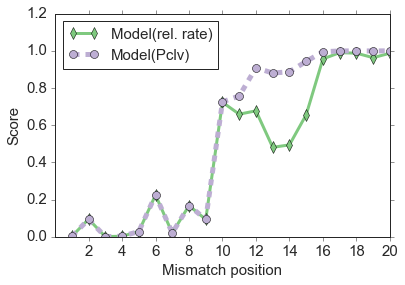

In [11]:
sns.set_palette('Accent');
plt.figure()
plt.plot(mm_positions,RelRate,marker='d',markersize=8,lw=3,label='Model(rel. rate)')
plt.plot(mm_positions,ProbCLV,marker='o',markersize=8,lw=5,ls='--',label='Model(Pclv)')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks(np.arange(0,1.5,0.2), fontsize=15);
plt.ylim([0,1.2]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('Score', fontsize=15);
plt.legend(fontsize=15, loc = 2);

### Comparison: model vs. CFD 

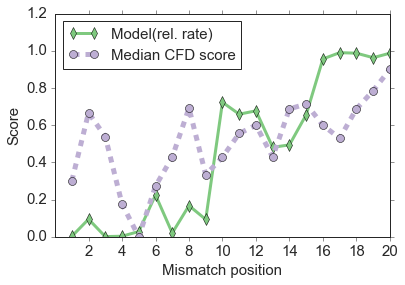

In [12]:
sns.set_palette('Accent');
plt.figure()
plt.plot(mm_positions,RelRate,marker='d',markersize=8,lw=3,label='Model(rel. rate)')
plt.plot(mm_positions,CFD_median_score,marker='o',markersize=8,lw=5,ls='--',label='Median CFD score')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks(np.arange(0,1.5,0.2), fontsize=15);
plt.ylim([0,1.2]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('Score', fontsize=15);
plt.legend(fontsize=15, loc = 2);

### Comparison: Model vs. Pattanayak data

In [13]:
Pattanayak_CLTA1_1mm = Pattanayak_CLTA1.copy()
Pattanayak_CLTA1_1mm['Position'] = Pattanayak_CLTA1_1mm['target - MMpos'].apply(lambda x: x[0])
Pattanayak_CLTA1_1mm = Pattanayak_CLTA1_1mm[Pattanayak_CLTA1_1mm['target - MMcount']==1][['Position', 'Score']]
Pattanayak_CLTA1_1mm = Pattanayak_CLTA1_1mm.groupby('Position').median().reset_index()

Pattanayak_CLTA4_1mm = Pattanayak_CLTA4.copy()
Pattanayak_CLTA4_1mm['Position'] = Pattanayak_CLTA4_1mm['target - MMpos'].apply(lambda x: x[0])
Pattanayak_CLTA4_1mm = Pattanayak_CLTA4_1mm[Pattanayak_CLTA4_1mm['target - MMcount']==1][['Position', 'Score']]
Pattanayak_CLTA4_1mm = Pattanayak_CLTA4_1mm.groupby('Position').median().reset_index()

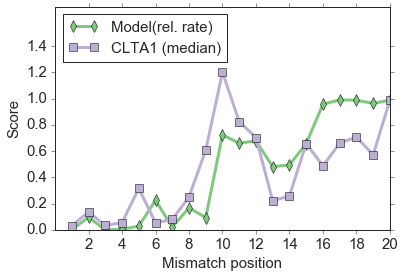

In [14]:
sns.set_palette('Accent');
plt.figure()
plt.plot(mm_positions,RelRate,marker='d',markersize=8,lw=3,label='Model(rel. rate)')
plt.plot(mm_positions,Pattanayak_CLTA1_1mm['Score'],marker='s',markersize=8,lw=3,ls='-',label='CLTA1 (median)')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks(np.arange(0,1.5,0.2), fontsize=15);
plt.ylim([0,1.7]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('Score', fontsize=15);
plt.legend(fontsize=15, loc = 2);

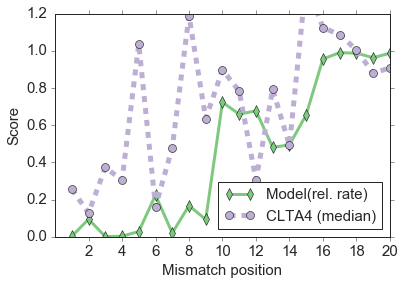

In [15]:
sns.set_palette('Accent');
plt.figure()
plt.plot(mm_positions,RelRate,marker='d',markersize=8,lw=3,label='Model(rel. rate)')
plt.plot(mm_positions,Pattanayak_CLTA4_1mm['Score'],marker='o',markersize=8,lw=5,ls='--',label='CLTA4 (median)')
plt.xticks(range(2,22,2), fontsize=15);
plt.yticks(np.arange(0,1.5,0.2), fontsize=15);
plt.ylim([0,1.2]);
plt.xlabel('Mismatch position', fontsize=15)
plt.ylabel('Score', fontsize=15);
plt.legend(fontsize=15, loc = 4);

# Model (Double mismatches)

In [16]:
two_mismatches = np.zeros((20,20))
for mm1 in range(1,21):
    for mm2 in range(1,21):
        two_mismatches[mm1-1,mm2-1] = (Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=[mm1,mm2],
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=10.0)/OnTarget)**(-1)

### Comparison: Model vs. Pattanayak data (CLTA1)

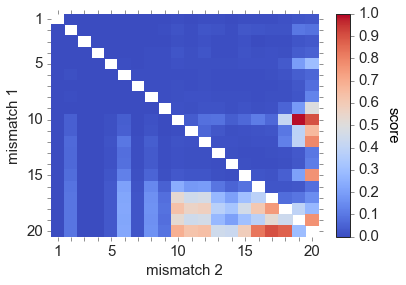

In [17]:
data = Pattanayak_CLTA1[Pattanayak_CLTA1['target - MMcount']==2].copy()
Matrix = np.zeros([20,20]) 
for n in range(len(data)):
    pos = data['target - MMpos'].iloc[n]
    pos1 = pos[0] -1
    pos2 = pos[1] -1
    Matrix[pos1,pos2] = data['Score'].iloc[n]

plt.figure()
mask = np.zeros(Matrix.shape)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(two_mismatches, mask=np.triu(two_mismatches),cbar=False, cmap='coolwarm', vmin=0, vmax=1)
axHeatmap = sns.heatmap(Matrix,cbar=False,mask=mask,cmap='coolwarm',vmin=0,vmax=1)

#axHeatmap.invert_xaxis()
#axHeatmap.invert_yaxis()
#axHeatmap.set_yticklabels([20,'','','','',15,'','','','',10,'','','','',5,'','','',1], fontsize=15 );
axHeatmap.set_yticklabels([1,'','','',5,'','','','',10,'','','','',15,'','','','',20], fontsize=15);
axHeatmap.set_xticklabels([1,'','','',5,'','','','',10,'','','','',15,'','','','',20] ,rotation=0, fontsize=15);
axHeatmap.set_ylabel('mismatch 1',fontsize=15);
axHeatmap.set_xlabel('mismatch 2',fontsize=15);
cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
cbar.set_label('score',size=15,rotation=-90,labelpad=20,color='black')
cbar.ax.tick_params(labelsize=15)

### Comparison: Model vs. Pattanayak data (CLTA4)

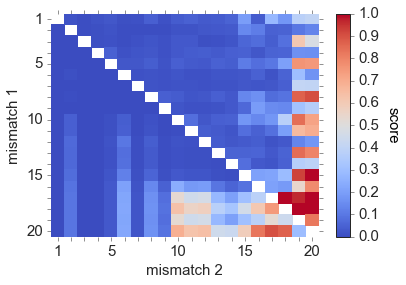

In [18]:
data = Pattanayak_CLTA4[Pattanayak_CLTA4['target - MMcount']==2].copy()
Matrix = np.zeros([20,20]) 
for n in range(len(data)):
    pos = data['target - MMpos'].iloc[n]
    pos1 = pos[0] -1
    pos2 = pos[1] -1
    Matrix[pos1,pos2] = data['Score'].iloc[n]

plt.figure()
mask = np.zeros(Matrix.shape)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(two_mismatches, mask=np.triu(two_mismatches),cbar=False, cmap='coolwarm', vmin=0, vmax=1)
axHeatmap = sns.heatmap(Matrix,cbar=False,mask=mask,cmap='coolwarm',vmin=0,vmax=1)

#axHeatmap.invert_xaxis()
#axHeatmap.invert_yaxis()
#axHeatmap.set_yticklabels([20,'','','','',15,'','','','',10,'','','','',5,'','','',1], fontsize=15 );
axHeatmap.set_yticklabels([1,'','','',5,'','','','',10,'','','','',15,'','','','',20], fontsize=15);
axHeatmap.set_xticklabels([1,'','','',5,'','','','',10,'','','','',15,'','','','',20] ,rotation=0, fontsize=15);
axHeatmap.set_ylabel('mismatch 1',fontsize=15);
axHeatmap.set_xlabel('mismatch 2',fontsize=15);
cbar = axHeatmap.figure.colorbar(axHeatmap.axes.collections[0],aspect=15);
cbar.set_label('score',size=15,rotation=-90,labelpad=20,color='black')
cbar.ax.tick_params(labelsize=15)

# Model (Multiple mismatches)

### Comparison: Model vs. Pattanayak data (CLTA1)

In [28]:
fldr = '../Pattanayak_data/'
Pattanayak = pd.read_excel(fldr+'Pattanayak_Liu_NBT_2673_Data.xlsx')
concentration = '100nM'
PAM = 'NGG'
name = 'CLTA1'

Pattanayak = Pattanayak[(Pattanayak.Concentration == concentration) & 
                        (Pattanayak.PAM == PAM) & (Pattanayak.name == name)]

Pattanayak = Pattanayak[Pattanayak['target - MMcount']>0]
Pattanayak['target - MMpos'] = Pattanayak['target - MMpos'].apply(lambda x: map(int,x.split(',')))

In [29]:
Pattanayak['TimeCLV'] = Pattanayak['target - MMpos'].apply(lambda x:Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=x,
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=10.0))
Pattanayak['rel_kclv'] = Pattanayak['TimeCLV'].apply(lambda x: OnTarget/x)

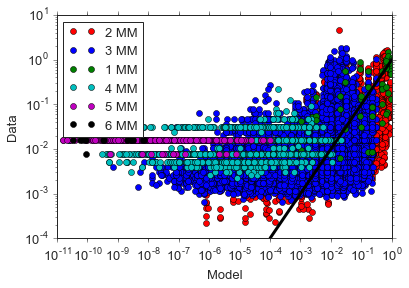

In [30]:
colors = ['r', 'b', 'g', 'c', 'm', 'k']

plt.figure()
n=0
for mm_num in [2,3,1,4,5,6]:
    data_plt = Pattanayak[Pattanayak['target - MMcount']==mm_num][['rel_kclv', 'Score']]
    plt.loglog(data_plt['rel_kclv'], data_plt['Score'], 'o', ls='', color=colors[n], alpha=1,label=str(mm_num)+' MM')
    n = n + 1
plt.plot([10**-4, 1],[10**-4, 1],'k-',lw=3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, loc='best')
plt.xlabel('Model', fontsize=13)
plt.ylabel('Data', fontsize=13);

#### pearson correlation

In [31]:
Pattanayak[['rel_kclv', 'Score']].corr(method='pearson')

,rel_kclv,Score
rel_kclv,1.000000,0.419759
Score,0.419759,1.000000


### Comparison: Model vs. Pattanayak data (CLTA4)

In [23]:
fldr = '../Pattanayak_data/'
Pattanayak = pd.read_excel(fldr+'Pattanayak_Liu_NBT_2673_Data.xlsx')
concentration = '100nM'
PAM = 'NGG'
name = 'CLTA4'

Pattanayak = Pattanayak[(Pattanayak.Concentration == concentration) & 
                        (Pattanayak.PAM == PAM) & (Pattanayak.name == name)]

Pattanayak = Pattanayak[Pattanayak['target - MMcount']>0]
Pattanayak['target - MMpos'] = Pattanayak['target - MMpos'].apply(lambda x: map(int,x.split(',')))

In [24]:
Pattanayak['TimeCLV'] = Pattanayak['target - MMpos'].apply(lambda x:Cas9.calc_Time(parameters=boyle_params,
                    mismatch_positions=x,
                    model_ID=model_id,
                    rate_to_cleave=rate_to_cleave,
                    rel_conc=10.0))
Pattanayak['rel_kclv'] = Pattanayak['TimeCLV'].apply(lambda x: OnTarget/x)

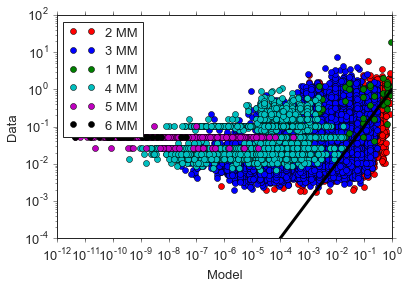

In [25]:
colors = ['r', 'b', 'g', 'c', 'm', 'k']

plt.figure()
n=0
for mm_num in [2,3,1,4,5,6]:
    data_plt = Pattanayak[Pattanayak['target - MMcount']==mm_num][['rel_kclv', 'Score']]
    plt.loglog(data_plt['rel_kclv'], data_plt['Score'], 'o', ls='', color=colors[n], alpha=1,label=str(mm_num)+' MM')
    n = n + 1
plt.plot([10**-4, 1],[10**-4, 1],'k-',lw=3)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, loc='best')
plt.xlabel('Model', fontsize=13)
plt.ylabel('Data', fontsize=13);

#### pearson correlation

In [27]:
Pattanayak[['rel_kclv', 'Score']].corr(method='pearson')

,rel_kclv,Score
rel_kclv,1.000000,0.380923
Score,0.380923,1.000000
